# Analysis for Sampling Ternary System

The experiment began shortly before 4pm on Wednesday, October 2nd, 2019. We continued with the same initial solution throughout the rest of the experimental time frame through October 11th, 2019 because of the time required to clean and reload the Parr reactor in the N2 glovebox (~1 day turnaround). Instead, we added cyclopentane to change the recipe by pumping it in with the ISCO pump.

### Concerns
    -Vapor leak changes composition of CO2, current method for accounting for it is heuristic and based on Huikuan's PC-SAFT model (which we were are trying to validate)
    -Vapor leak also changes composition of C5, which I have not accounted for
    -Not getting good matching for high pressure or low temperature, possibly because of drift in accuracy of composition
    -Vapor phase sampling is at a much lower pressure and typically lower temperature (ambient for both) than the headspace in the Parr reactor, resulting in a much lower pressure of the vapor in the GC, so the density must be corrected with a PC-SAFT estimate of the total density (only weight fractions are used from GC, which may be inaccurate in the case of evaporation of a liquid headspace at high pressures)
    -A non-negligible amount of liquid is extracted for sampling (1-2 mL), which can dramatically change the amount of polyol and cyclopentane (and perhaps even CO2) in the Parr reactor. Because we don't know exactly how much is sampled, however, we must rely on a heuristic estimate to predict the amount that has been lost due to sampling at each measurement. So far, this heuristic assumes that only cyclopentane and polyol have been sampled, but perhaps we should include CO2 as well.
    
#### Correcting for CO2 Leak

If I don't correct for leak, the data are obviously off, with the expected density of CO2 being greater than the density in either of the sampled phases. If I use the mass of CO2 predicted under the conditions of each experiment by the PC-SAFT model, I underestimate the CO2 mass resulting in a total density around the measured density of CO2 in the vapor phase (although the density of CO2 in the vapor phase is modified based on the predicted density of the vapor phase assuming the same density as a CO2-C5 mixture in equilibrium with its liquid phase). Right now, I am estimating the leak based on the drop in expected mass predicted by the PC-SAFT model during each pressure step, which assumes a constant leak rate for each pressure step. The result is something in between, and thus, reasonable, but likely still inaccurate (I think it overestimates the density from my observations). Nevertheless, I cannot justify another approximation that would more accurately estimate the amount of CO2 lost through the leak.

In [1]:
import pandas as pd
import numpy as np
import pickle as pkl

import tern
import experiment
from timedate import TimeDate
import plot
experiment.__name__='Experiment'
from importlib import reload
reload(tern)
reload(experiment)

# set user parameters
save_folder = ''
experiment_save_filename = 'experiment_objects.pkl'

In [6]:
print(np.sum(tern.rho_v_co2_c5(1070, 42, 0.97, 0.03)))
print(np.sum(tern.rho_v_co2_c5(880, 42, 0.97, 0.03)))

print(np.sum(tern.rho_v_co2_c5(870, 43, 0.92, 0.08)))
print(np.sum(tern.rho_v_co2_c5(15, 43, 0.92, 0.08)))

print(np.sum(tern.rho_v_co2_c5(15, 22, 0.63, 0.37)))

0.2305297473448276
0.156831255
0.153337839
0.0026929221724137932
0.23361478083911022


In [135]:
##### initialize experiment
v_leak = 5
w_poly = 0.51
rho_poly = 1.02
rho_c5 = 0.751
purity_c5_a = 0.99073 # cyclopentane from GC lab; measured by Marla Gilbert with GC
m_c5_a = 54.55 # [g]
purity_c5_b = 0.98 # cyclopentane ordered from Sigma; read from the bottle
m_c5_b = 27.46 # [g]
m_poly = 86.59
m_poly -= w_poly*v_leak*rho_poly # lost some mass while loading
m_c5 = purity_c5_a*m_c5_a + purity_c5_b*m_c5_b
m_c5 -= (1-w_poly)*v_leak*rho_c5 # lost some mass while loading
m_impurities = (1-purity_c5_a)*m_c5_a + (1-purity_c5_b)*m_c5_b
V = 1200 # volume of the Parr reactor [mL]; read from manual
p_isco = 1000 # [psi] what's the offset? what's the pressure in the co2 tank?
T_isco = 21 # [C]
V_isco = 371 # [mL]
timedate_0 = TimeDate(date_str='10/02/2019', time_str='15:50:00')
mixing_rate = 10 # [RPM]

exp = experiment.Experiment(m_poly, m_c5, m_impurities, V, p_isco, T_isco, V_isco, timedate_0, mixing_rate)

In [136]:
pa_f_co2 = [3.0E7, 6.62E7, 7.12E7, 2.09E8, 2.14E8, 2.10E8, 2.09E8, 2.08E8, -1, 2.44E8, 3.30E8,
           -1, 3.42E8, 3.40E8, 3.19E8, 3.12E8, 3.01E8, 2.99E8, 3.90E8, 3.59E8, 3.64E8, 3.81E8, 3.53E8,
           3.48E8, 3.91E8, 3.92E8] #, 3.62E8]
pa_f_c5 = [1.23E9, 1.16E9, 1.15E9, 9.57E8, 9.42E8, 9.26E8, 9.33E8, 9.35E8, -1, 8.48E8, 7.23E8,
          -1, 6.97E8, 7.07E8, 7.21E8, 7.24E8, 7.35E8, 7.34E8, 6.17E8, 5.92E8, 6.06E8, 5.29E8, 4.7E8,
          4.79E8, 5.31E8, 5.28E8] #, 6.92E8]
pa_b_co2 = [4.04E7, 5.27E7, 5.67E7, 6.08E7, 5.84E7, 5.79E7, 5.96E7, 5.84E7, -1, 6.13E7, 6.03E7,
           -1, 5.94E7, 5.8E7, 6.01E7, 6.02E7, 6.24E7, 8.84E7, 7.03E7, 1.01E8, 1.11E8, 1.06E8, 1.22E8,
           1.16E8, 8.54E7, 9.71E7] #, 7.73E7]
pa_b_c5 = [1.08E7, 7.23E6, 6.29E6, 4.44E6, 4.05E6, 3.58E6, 3.46E6, 3.65E6, -1, 1.91E6, 4.98E5,
          -1, 1.22E6, 8.33E5, 4.69E5, 6.39E5, 1.64E6, 3.39E6, 2.92E6, 1.03E7, 7.17E6, 1.1E7, 7.75E6,
          1.05E7, 2.13E6, 2.93E6] #, 1.68E6]
p_parr = [375, 350, 350, 740, 740, 750, 755, 755, 885, 885, 990, 995, 995, 1000, 990, 990, 990, 
          985, 1075, 1045, 1040, 1110, 1095, 1100, 980, 980] #, 915]
T = [41, 39, 38, 34, 33, 36, 39, 41, 41, 40, 39, 40, 34, 37, 39, 39, 38, 37, 38, 37, 36, 36, 36, 37, 31, 31] #, 30]
V_isco = [289.1, 282.88, 282.5, 139.9, 139.9, 139.9, 139.3, 274, 203, 196.3, 105.33, 105.15, 
          103.54, 103.38, 101.73, 101.53, 101.35, 101.18, 5.80, 240.13, 239.73, 107.72, 105.31, 103.32, 
         92.70, 92.62] #, 41.35]
p_isco = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1200, 1200, 1200, 1400, 1400, 1400, 1400,
         1400, 1400, 1400, 1400, 1400, 1150, 1150, 1400, 1400, 1400, 1400, 1400] #, 1100]
sampled_liquid = np.ones([len(p_isco)])
sampled_liquid[[16, 17]] = False
# volume of vapor sampled as measured by flow meter at atmospheric conditions connected to outlet of gas-sampling valve [mL]
V_vap_sampled_atm = [4, 2, 2, 3, 1, 1.5, 5.3, 3.5, 5, 6, 7, 6, 6, 5, 13, 15, 150, 350, 150, 400, 400, 400, 500, 300, 380, 380]
timedate = [TimeDate(date_str='10/02/2019', time_str='15:50:44'),
            TimeDate(date_str='10/03/2019', time_str='9:09:35'),
           TimeDate(date_str='10/03/2019', time_str='9:19:54'),
           TimeDate(date_str='10/03/2019', time_str='12:38:37'),
           TimeDate(date_str='10/03/2019', time_str='12:51:33'),
           TimeDate(date_str='10/03/2019', time_str='14:42:25'),
           TimeDate(date_str='10/03/2019', time_str='15:49:22'),
           TimeDate(date_str='10/03/2019', time_str='16:01:11'),
           TimeDate(date_str='10/04/2019', time_str='8:49:00'),
           TimeDate(date_str='10/04/2019', time_str='8:59:43'),
             TimeDate(date_str='10/04/2019', time_str='10:41:03'),
           TimeDate(date_str='10/04/2019', time_str='10:54:00'),
           TimeDate(date_str='10/04/2019', time_str='12:21:18'),
           TimeDate(date_str='10/04/2019', time_str='12:29:36'),
           TimeDate(date_str='10/04/2019', time_str='14:29:50'),
           TimeDate(date_str='10/04/2019', time_str='14:42:26'),
           TimeDate(date_str='10/04/2019', time_str='14:55:47'),
           TimeDate(date_str='10/04/2019', time_str='15:05:49'),
           TimeDate(date_str='10/04/2019', time_str='16:31:34'),
           TimeDate(date_str='10/07/2019', time_str='9:24:42'),
           TimeDate(date_str='10/07/2019', time_str='9:34:46'),
           TimeDate(date_str='10/07/2019', time_str='11:05:36'),
           TimeDate(date_str='10/07/2019', time_str='14:17:50'),
           TimeDate(date_str='10/07/2019', time_str='14:24:00'), #???
           TimeDate(date_str='10/08/2019', time_str='8:34:34'),
           TimeDate(date_str='10/08/2019', time_str='8:40:00')] #,
          # TimeDate(date_str='10/08/2019', time_str='13:55:00')] # ???
# pressure step data
inds_p_step = [0, 3, 8, 10, 18, 21, 23] #, 24] # indices before which Parr was pressurized
p0 = [390, 795, 910, 1000, 1050, 1110, 980] #, 940]
T0 = [41, 36, 40, 37, 35, 36, 31] #, 32]
# p_isco_i = [0, 1000, 1200, 1200, 1400, 1400]
# V_isco_i = [0, 282.5, 274, 196.3, 101, 232.8]
# p_isco_f = [1000, 1000, 1200, 1400, 1400, 1400]
# V_isco_f = [289.1, 134.16, 203, 107.9, 5.8, 109.6]
# p_isco_refill = [845, -1, 838, -1, -846, -1]
p_isco_i = [1000, 1000, 1200, 1200, 1400, 1400, 1400] #, 1100]
V_isco_i = [370, 282.5, 274, 196.3, 101, 232.8, 92.7] #, 71.23]
p_isco_f = [1000, 1000, 1200, 1400, 1400, 1400, 1400] #, 1100]
V_isco_f = [289.1, 134.16, 203, 107.9, 5.8, 109.6, 92.7] #, 41.26]
p_isco_refill = [-1, -1, -1, -1, -846, -1, -1] #, -1]
p_step_timedate = [TimeDate(date_str='10/02/2019', time_str='15:50:00'),
                  TimeDate(date_str='10/03/2019', time_str='9:30:00'),
                  TimeDate(date_str='10/03/2019', time_str='16:10:00'),
                  TimeDate(date_str='10/04/2019', time_str='9:10:00'),
                  TimeDate(date_str='10/04/2019', time_str='15:20:00'),
                  TimeDate(date_str='10/07/2019', time_str='9:48:00'),
                  TimeDate(date_str='10/08/2019', time_str='8:34:34')]#,
#                   TimeDate(date_str='10/08/2019', time_str='11:30:00')]
# c5 = np.zeros([len(p_step_timedate)])
# c5[7] = True
leak_rate_list = []

p_step_coll = []
for i in range(len(pa_f_co2)):
    # load new pressure step
    if i in inds_p_step:
        ip = inds_p_step.index(i)
        p_step_coll += [experiment.PressureStep(exp, p0[ip], T0[ip], p_isco_i[ip], V_isco_i[ip], p_isco_f[ip], V_isco_f[ip],
                                p_step_timedate[ip], p_isco_refill=p_isco_refill[ip])]
    # load new measurement
    meas = experiment.Measurement(p_step_coll[ip], pa_f_co2[i], pa_f_c5[i], pa_b_co2[i], pa_b_c5[i], 
                                  p_parr[i], T[i], V_isco[i], V_vap_sampled_atm[i], timedate[i], p_isco=p_isco[i], 
                                 sampled_liquid=sampled_liquid[i])
    
# create dataframe and save as csv
pc_saft_folder = '../../../Wang/PC-SAFT/Data/'
df_filename = 'gc_ternary_50%_c5_data.csv'
df = exp.to_df()
df.to_csv(pc_saft_folder+df_filename)

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [137]:
reload(experiment)
# create new experiment for c5 addition--note that this measurement is still in original experiment
V_leak2 = 1 # volume of leak [mL]
rho_l_poly = exp.p_step_list[-1].measurement_list[-1].rho_l_poly
rho_l_c5 = exp.p_step_list[-1].measurement_list[-1].rho_l_c5
T_atm = 21 # [C]
V_c5_injected = (71.23-41.26) # [mL]
m_poly = exp.m_poly - rho_l_poly*V_leak2
m_c5 = exp.m_c5 - rho_l_c5*V_leak2 + tern.rho_c5(T_atm)*V_c5_injected
m_co2 = exp.m_co2
m_impurities = exp.m_impurities
p_isco = 1100 # [psi]
T_isco = 21 # [C]
V_isco = 41.26 # [mL]
timedate_0 = TimeDate(date_str='10/08/2019', time_str='11:30:00')
exp2 = experiment.Experiment(m_poly, m_c5, m_impurities, V, p_isco, T_isco, V_isco, timedate_0, mixing_rate, m_co2=m_co2)

pa_f_co2 = [3.62E8, 3.57E8]
pa_f_c5 = [6.92E8, 7.23E8]
pa_b_co2 = [7.73E7, 8.10E7]
pa_b_c5 = [1.68E6, 2.80E6]
p_parr = [915, 910]
T = [30, 30]
V_isco = [41.35, 41.35]
p_isco = [1100, 1100]
V_vap_sampled_atm = [450, 250]
timedate = [TimeDate(date_str='10/08/2019', time_str='13:55:00'),
           TimeDate(date_str='10/08/2019', time_str='15:36:51')]
# pressure step data
inds_p_step = [0] # indices before which Parr was pressurized
p0 = [940]
T0 = [32]
p_isco_i = [1100]
V_isco_i = [71.23]
p_isco_f = [1100]
V_isco_f = [41.26]
p_isco_refill = [-1]
p_step_timedate = [TimeDate(date_str='10/08/2019', time_str='11:30:01')]
c5 = [True]

p_step_coll = []
for i in range(len(pa_f_co2)):
    # load new pressure step
    if i in inds_p_step:
        ip = inds_p_step.index(i)
        p_step_coll += [experiment.PressureStep(exp2, p0[ip], T0[ip], p_isco_i[ip], V_isco_i[ip], p_isco_f[ip], V_isco_f[ip],
                                p_step_timedate[ip], c5=c5[ip])]
    # load new measurement
    meas = experiment.Measurement(p_step_coll[ip], pa_f_co2[i], pa_f_c5[i], pa_b_co2[i], pa_b_c5[i], 
                                  p_parr[i], T[i], V_isco[i], V_vap_sampled_atm[i], timedate[i], p_isco=p_isco[i], 
                                 sampled_liquid=sampled_liquid[i])
    
# create dataframe and save as csv
pc_saft_folder = '../../../Wang/PC-SAFT/Data/'
df2_filename = 'gc_ternary_55%_c5_data.csv'
df2 = exp2.to_df()
df2.to_csv(pc_saft_folder+df2_filename)

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [138]:
reload(experiment)
# create new experiment for c5 addition--note that this measurement is still in original experiment
V_c5_injected = 41.34-11.35 # [mL]
T_atm = 21 # [C]
m_poly = exp2.m_poly
m_c5 = exp2.m_c5 + tern.rho_c5(T_atm)*V_c5_injected
m_co2 = exp2.m_co2
m_impurities = exp2.m_impurities
p_isco = 1100 # [psi]
T_isco = 21 # [C]
V_isco = 11.35 # [mL]
timedate_0 = TimeDate(date_str='10/08/2019', time_str='15:53:00')
exp3 = experiment.Experiment(m_poly, m_c5, m_impurities, V, p_isco, T_isco, V_isco, timedate_0, mixing_rate, m_co2=m_co2)

pa_f_co2 = [3.13E8, 3.16E8, 4.01E8, 4.2E8, 4.14E8, 2.08E8, 4.27E8, 3.79E8, 2.37E8, 6.66E6]
pa_f_c5 = [9.28E8, 9.28E8, 7.53E8, 7.03E8, 6.43E8, 1.10E9, 7.37E8, 3.79E8, 1.01E9, 1.37E9]
pa_b_co2 = [7.36E7, 7.21E7, 7.63E7, 6.48E7, 7.38E7, 6.71E7, 1.22E8, 1.20E8, 3.61E8, 4.37E7]
pa_b_c5 = [3.5E6, 3.54E6, 2.37E6, 1.02E6, 2.19E6, 5.45E6, 4.01E6, 9.19E6, 9.21E7, 8.21E7]
p_parr = [840, 820, 865, 870, 850, 750, 1040, 1080, 880, 25]
T = [32, 31, 21, 20, 19, 38, 39, 42, 43, 22]
V_isco = [0, 0, 203.95, 84.55, 84.35, 81.28, 12.22, 11.5, 507.95, 507.95]
p_isco = [0, 0, 1200, 1350, 1350, 1350, 1350, 1350, 273, 273]
V_vap_sampled_atm = [300, 400, 300, 150, 300, 350, 250, 250, 300, 20]
timedate = [TimeDate(date_str='10/09/2019', time_str='8:30:28'),
           TimeDate(date_str='10/09/2019', time_str='8:42:48'),
           TimeDate(date_str='10/09/2019', time_str='12:29:43'),
           TimeDate(date_str='10/09/2019', time_str='14:50:56'),
           TimeDate(date_str='10/09/2019', time_str='16:40:26'), 
           TimeDate(date_str='10/10/2019', time_str='9:09:04'),
           TimeDate(date_str='10/10/2019', time_str='12:34:23'),
           TimeDate(date_str='10/10/2019', time_str='15:53:01'),
           TimeDate(date_str='10/11/2019', time_str='8:33:03'),
           TimeDate(date_str='10/11/2019', time_str='12:50:14')]
# pressure step data
inds_p_step = [0, 2, 3, 6, 8, 9] # indices before which Parr was pressurized
p0 = [890, 990, 905, 1080, 890, 25]
T0 = [33, 27, 21, 38, 42, 22]
p_isco_i = [0, 1200, 1200, 1350, 1350, 273]
V_isco_i = [0, 408.9, 203.95, 247.0, 11.5, 507.95]
p_isco_f = [0, 1200, 1350, 1350, 1350, 273]
V_isco_f = [0, 206.5, 85, 13.56, 11.5, 507.95]
p_isco_refill = [-1, -1, -1, -1, -1, -1]
p_step_timedate = [TimeDate(date_str='10/08/2019', time_str='16:55:00'),
                   TimeDate(date_str='10/09/2019', time_str='8:50:00'),
                  TimeDate(date_str='10/09/2019', time_str='13:00:00'),
                  TimeDate(date_str='10/10/2019', time_str='11:30:00'),
                  TimeDate(date_str='10/10/2019', time_str='16:00:00'),
                  TimeDate(date_str='10/11/2019', time_str='10:00:00')]

p_step_coll = []
for i in range(len(pa_f_co2)):
    # load new pressure step
    if i in inds_p_step:
        ip = inds_p_step.index(i)
        p_step_coll += [experiment.PressureStep(exp3, p0[ip], T0[ip], p_isco_i[ip], V_isco_i[ip], p_isco_f[ip], V_isco_f[ip],
                                p_step_timedate[ip])]
    # load new measurement
    meas = experiment.Measurement(p_step_coll[ip], pa_f_co2[i], pa_f_c5[i], pa_b_co2[i], pa_b_c5[i], 
                                  p_parr[i], T[i], V_isco[i], V_vap_sampled_atm[i], timedate[i], p_isco=p_isco[i])
    
# create dataframe and save as csv
pc_saft_folder = '../../../Wang/PC-SAFT/Data/'
df3_filename = 'gc_ternary_60%_c5_data.csv'
df3 = exp3.to_df()
df3.to_csv(pc_saft_folder+df3_filename)

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [139]:
[print(m.rho_v_co2, m.p, m.T) for p_step in exp.p_step_list for m in p_step.measurement_list if not m.is_error]

0.0461081740687795 365 41
0.04474143675510626 340 39
0.04512560071850609 340 38
0.12392397467070047 730 34
0.12398985737988516 730 33
0.12256856174225662 740 36
0.12393937849338325 745 39
0.11999981994830033 745 41
0.1511534201988584 875 40
0.1977187968432388 980 39
0.21023378401894247 985 34
0.20103642023709473 990 37
0.197735906622746 980 39
0.19757386766909749 980 39
0.19675023933332914 980 38
0.19497029753143028 975 37
0.2366773954737195 1065 38
0.21711483538813978 1035 37
0.21704616291518133 1030 36
0.25536898469904445 1100 36
0.24726384660736317 1085 36
0.24850284281070173 1090 37
0.21687787104166653 970 31
0.2168131089312167 970 31


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [140]:
[print(m.rho_v_c5*(exp.V-m.V_liq), m.p, m.T) for p_step in exp.p_step_list for m in p_step.measurement_list if not m.is_error]

4.81052850454557 365 41
2.7330202293770567 340 39
2.3504775345379416 340 38
4.761066406957164 730 34
4.7115538588683314 730 33
4.421453180906827 740 36
4.273442957204212 745 39
4.339988527548609 745 41
3.944782751548762 875 40
3.7533713355440974 980 39
4.86665891894079 985 34
4.345683950630042 990 37
3.805402875440801 980 39
3.988151941195339 980 39
4.83794725057996 980 38
4.683719627541037 975 37
6.42682350573705 1065 38
9.375753685805638 1035 37
6.5695466070426685 1030 36
11.139218538434292 1100 36
7.440023580763131 1085 36
9.826222892561796 1090 37
4.425265693612989 970 31
4.501117513033629 970 31


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [141]:
df = exp.to_df()

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [142]:
df3

,date,time,elapsed time [min],pressure [psi],temperature [C],mass co2 [g],mass co2 (leak) [g],mass co2 [g] (corr),mass c5 [g],mass polyol [g],...,w polyol (tot) [w/w],w co2 (tot) [w/w] (corr),w c5 (tot) [w/w] (corr),w polyol (tot) [w/w] (corr),liquid volume [mL],mass c5 (pred) [g],mass c5 (missing) [g],mass co2 (pred) [g],mass co2 (missing) [g],is error
0,10/9/2019,8:30:28,997,830,32,288.227,NaN,NaN,134.18,60.9734,...,0.125865,NaN,NaN,NaN,212.013,63.9693,70.2105,217.974,70.2533,False
1,10/9/2019,8:42:48,1009,810,31,287.334,NaN,NaN,133.61,60.4022,...,0.125212,NaN,NaN,NaN,211.493,63.9594,69.6502,219.37,67.9643,False
2,10/9/2019,12:29:43,1236,855,21,453.017,NaN,NaN,133.149,59.8369,...,0.0924754,NaN,NaN,NaN,211.714,52.5207,80.628,266.138,186.879,False
3,10/9/2019,14:50:56,1377,860,20,548.656,NaN,NaN,132.72,59.2666,...,0.0799067,NaN,NaN,NaN,207.838,48.0806,84.6398,271.157,277.499,False
4,10/9/2019,16:40:26,1487,840,19,547.683,NaN,NaN,132.327,58.6337,...,0.079267,NaN,NaN,NaN,185.268,41.5219,90.805,310.798,236.885,False
5,10/10/2019,9:09:04,2476,740,38,547.002,NaN,NaN,131.65,58.0041,...,0.078627,NaN,NaN,NaN,184.255,66.4823,65.1677,165.1,381.903,False
6,10/10/2019,12:34:23,2681,1030,39,741.969,NaN,NaN,131.199,57.5108,...,0.0617245,NaN,NaN,NaN,233.178,56.2087,74.9905,314.599,427.37,False
7,10/10/2019,15:53:01,2880,1070,42,741.024,NaN,NaN,130.963,56.6324,...,0.0609164,NaN,NaN,NaN,128.955,22.7544,108.209,289.601,451.423,False
8,10/11/2019,8:33:03,3880,870,43,739.669,NaN,NaN,130.277,55.9961,...,0.0604059,NaN,NaN,NaN,175.987,66.3486,63.9285,188.893,550.775,False
9,10/11/2019,12:50:14,4137,15,22,739.617,NaN,NaN,129.443,55.1561,...,0.0596107,NaN,NaN,NaN,131.321,146.618,-17.1748,160.714,578.903,False


## Demonstrate equilibrium time of ternary system

(0, 300000000.0)

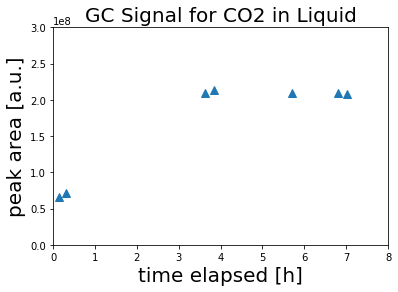

In [143]:
import matplotlib.pyplot as plt

# demonstration
inds = [not m.is_error for p_step in exp.p_step_list for m in p_step.measurement_list]
plt.plot((df['elapsed time [min]'].to_numpy(dtype=float)[inds]-1030)/60, 
         df['peak area (front) co2 [a.u.]'].to_numpy(dtype=float)[inds], 
#             df['pressure [psi]'].to_numpy(dtype=float)[inds], 
         '^', lw=0, ms=8)
plt.xlabel('time elapsed [h]', fontsize=20)
plt.ylabel('peak area [a.u.]', fontsize=20)
plt.title('GC Signal for CO2 in Liquid', fontsize=20)
plt.xlim([0,8])
plt.ylim([0, 3.0E8])

(6, 35)

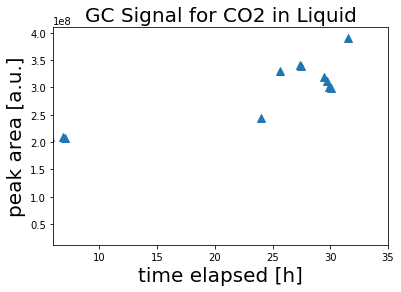

In [144]:
plt.plot((df['elapsed time [min]'].to_numpy(dtype=float)[inds]-1030)/60, 
         df['peak area (front) co2 [a.u.]'].to_numpy(dtype=float)[inds], 
#             df['pressure [psi]'].to_numpy(dtype=float)[inds], 
         '^', lw=0, ms=8)
plt.xlabel('time elapsed [h]', fontsize=20)
plt.ylabel('peak area [a.u.]', fontsize=20)
plt.title('GC Signal for CO2 in Liquid', fontsize=20)
plt.xlim([6,35])

Text(0.5,1,'GC Signal for CO2 in Liquid')

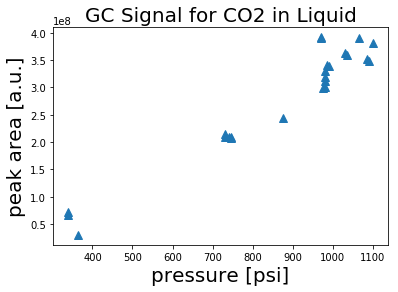

In [145]:
plt.plot(df['pressure [psi]'].to_numpy(dtype=float)[inds], 
         df['peak area (front) co2 [a.u.]'].to_numpy(dtype=float)[inds], 
#             df['pressure [psi]'].to_numpy(dtype=float)[inds], 
         '^', lw=0, ms=8)
plt.xlabel('pressure [psi]', fontsize=20)
plt.ylabel('peak area [a.u.]', fontsize=20)
plt.title('GC Signal for CO2 in Liquid', fontsize=20)

(0, 1200)

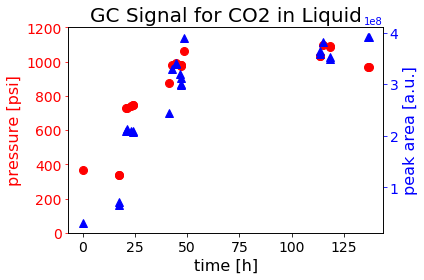

In [146]:
ax1, ax2 = plot.plot_two_axes(df['elapsed time [min]'].to_numpy(dtype=float)[inds]/60,
                   df['pressure [psi]'].to_numpy(dtype=float)[inds], 
         df['peak area (front) co2 [a.u.]'].to_numpy(dtype=float)[inds], 
                   xlabel='time [h]', ylabels=['pressure [psi]', 'peak area [a.u.]'],
                   title='GC Signal for CO2 in Liquid')
ax1.set_ylim([0,1200])

## Demonstrate effect of waiting after stopping mixing

Didn't see any effect. Not sure what to plot here.

[0, 0, 0, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 6, 6, 6]
[-0.008620689655172414, -0.01567398119122257, 0.0021436227224008574, 0.014347202295552367, 0.004160887656033287, 0.015193370165745856, -0.0013605442176870747, 0.02364864864864865, 0.019148936170212766, -0.005649717514124294]


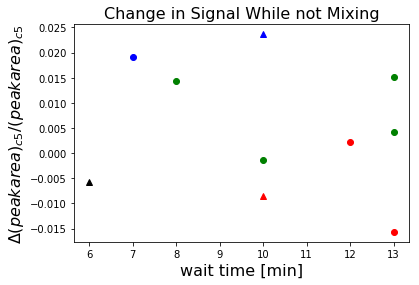

In [147]:
# max time of waiting within a single pair of consecutive measurements at the same condition
dt_max = 15
m_list = [m for p_step in exp.p_step_list for m in p_step.measurement_list if not m.is_error]
color_inds = []
for i in range(len(m_list)):
    m = m_list[i]
    ind = exp.p_step_list.index(m.p_step)
    color_inds += [ind]
print(color_inds)
color_list = ['r', 'g', 'b', 'k', 'c', 'm', 'y']
marker_list = ['^', 'o']
color_marker_list = [(color, marker) for color in color_list for marker in marker_list]
p_list = [m.p for m in m_list]
dt_list = [m_list[i+1].elapsed_time - m_list[i].elapsed_time 
           for i in range(len(m_list)-1)]
dpa_f_c5_list =  [m_list[i+1].pa_f_c5 - m_list[i].pa_f_c5 for i in range(len(m_list)-1)]
dt_stop_mixing = np.array([dt for dt in dt_list if dt < dt_max])
stop_mixing_data = [(dt_list[i], dpa_f_c5_list[i]/m_list[i].pa_f_c5, p_list[i], color_marker_list[color_inds[i]])
                             for i in range(len(dpa_f_c5_list)) if dt_list[i] < dt_max]
dt_stop_mixing = [elem[0] for elem in stop_mixing_data]
dpa_f_c5_stop_mixing = [elem[1] for elem in stop_mixing_data]
color_markers = [elem[3] for elem in stop_mixing_data]
print(dpa_f_c5_stop_mixing)
ax = plot.plot_line(dt_stop_mixing[0], dpa_f_c5_stop_mixing[0], marker=color_marker_list[0][1], xlabel='wait time [min]', 
                   ylabel=r'$\Delta(peak area)_{c5}/(peak area)_{c5}$', title='Change in Signal While not Mixing',
                  t_fs=16, color=color_marker_list[0][0])
for i in range(1, len(dt_stop_mixing)):
    c, m = color_markers[i]
    ax = plot.plot_line(dt_stop_mixing[i], dpa_f_c5_stop_mixing[i], ax=ax, marker=m, color=c)

## Weight Fractions for Comparison to PC-SAFT Phase Diagrams

Below we read out the computed weight fractions at each pressure to compare to predictions from the PC-SAFT model.

In [148]:
[print('p = {0:.1f} MPa : T = {1:d} C : w_c5 (liq) = {2:.2f} : w_co2 (liq) = {3:.2f} : w_c5 (vap) = {4:.2f} : w_co2 (vap) = {5:.2f} : w_poly_tot = {6:.2f}: w_c5_tot = {7:.2f}'\
       .format(m.p/145, m.T, m.w_l_c5, m.w_l_co2, m.w_v_c5, m.w_v_co2, m.m_poly/(m.m_poly+m.m_c5+m.m_co2), m.m_c5/(m.m_poly+m.m_c5+m.m_co2))) for p_step in exp.p_step_list for m in 
       p_step.measurement_list if not m.is_error]

p = 2.5 MPa : T = 41 C : w_c5 (liq) = 0.44 : w_co2 (liq) = 0.05 : w_c5 (vap) = 0.09 : w_co2 (vap) = 0.91 : w_poly_tot = 0.46: w_c5_tot = 0.44
p = 2.3 MPa : T = 39 C : w_c5 (liq) = 0.41 : w_co2 (liq) = 0.10 : w_c5 (vap) = 0.06 : w_co2 (vap) = 0.94 : w_poly_tot = 0.46: w_c5_tot = 0.44
p = 2.3 MPa : T = 38 C : w_c5 (liq) = 0.40 : w_co2 (liq) = 0.10 : w_c5 (vap) = 0.05 : w_co2 (vap) = 0.95 : w_poly_tot = 0.46: w_c5_tot = 0.44
p = 5.0 MPa : T = 34 C : w_c5 (liq) = 0.33 : w_co2 (liq) = 0.25 : w_c5 (vap) = 0.04 : w_co2 (vap) = 0.96 : w_poly_tot = 0.39: w_c5_tot = 0.37
p = 5.0 MPa : T = 33 C : w_c5 (liq) = 0.32 : w_co2 (liq) = 0.26 : w_c5 (vap) = 0.04 : w_co2 (vap) = 0.96 : w_poly_tot = 0.39: w_c5_tot = 0.37
p = 5.1 MPa : T = 36 C : w_c5 (liq) = 0.31 : w_co2 (liq) = 0.25 : w_c5 (vap) = 0.03 : w_co2 (vap) = 0.97 : w_poly_tot = 0.39: w_c5_tot = 0.37
p = 5.1 MPa : T = 39 C : w_c5 (liq) = 0.32 : w_co2 (liq) = 0.25 : w_c5 (vap) = 0.03 : w_co2 (vap) = 0.97 : w_poly_tot = 0.39: w_c5_tot = 0.37
p = 5.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [149]:
exp.m_co2

290.91962017551714

In [150]:
exp.get_p()

array([ 365,  340,  340,  730,  730,  740,  745,  745,  875,  875,  980,
        985,  985,  990,  980,  980,  980,  975, 1065, 1035, 1030, 1100,
       1085, 1090,  970,  970])

In [151]:
[p_step.m_co2 for p_step in exp.p_step_list]

[18.06462071679782,
 50.74468209532125,
 94.7031021688401,
 143.4655115739076,
 209.07665712156057,
 295.8340535817582,
 293.81922527131155]

(0, 3500000.0)

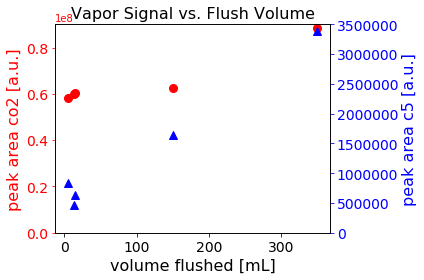

In [152]:
reload(plot)
m_gas = exp.get_meas(p_min=960, p_max=965, T_max=38)
p_gas = [m.p for m in m_gas] 
pa_b_co2_arr = df['peak area (back) co2 [a.u.]'].iloc[13:18]
pa_b_c5_arr = df['peak area (back) c5 [a.u.]'].iloc[13:18]
V_flush = np.array([5, 13, 15, 150, 350])
ax1, ax2 = plot.plot_two_axes(V_flush, pa_b_co2_arr, pa_b_c5_arr, xlabel='volume flushed [mL]', ylabels=['peak area co2 [a.u.]',
                                                                                                  'peak area c5 [a.u.]'],
              title='Vapor Signal vs. Flush Volume', t_fs=16, labels=['CO2', 'C5'])
ax1.set_ylim([0, 9.0E7])
ax2.set_ylim([0, 3.5E6])

### Check that the amount of CO2 injected in the Parr reactor makes sense

I'm concerned that I'm not calculating the amount of CO2 dispensed into the Parr reactor correctly.

*The problem was that I was assuming that when we refilled the ISCO, it was completely liquid. Instead, it is likely that it is in vapor-liquid equilibrium with a headspace. For this reason, I need to pressurize the ISCO after refilling and record **that** pressure and volume.*

In [153]:
# more co2 is dispensed in the Parr reactor than has been loaded in the ISCO pump by my calculations
[p_step.m_co2 - p_step.m_co2_refill for p_step in exp.p_step_list]

[18.06462071679782,
 50.74468209532125,
 -53.827600727614964,
 -5.065191322547463,
 -14.884402373627552,
 -69.40200970742399,
 -71.41683801787065]

In [154]:
[print(p_step.p_isco_i, p_step.V_isco_i, p_step.p_isco_f, p_step.V_isco_f, p_step.m_co2) for p_step in exp.p_step_list]

1000 370 1000 289.1 18.06462071679782
1000 282.5 1000 134.16 50.74468209532125
1200 274 1200 203 94.7031021688401
1200 196.3 1400 107.9 143.4655115739076
1405 101 1405 5.8 209.07665712156057
1400 232.8 1400 109.6 295.8340535817582
1400 92.7 1400 92.7 293.81922527131155


[None, None, None, None, None, None, None]

In [155]:
exp.m_poly/(exp.m_co2+exp.m_c5+exp.m_poly)

0.14958082481592233

In [156]:
print(exp3.m_co2, exp3.m_poly, exp3.m_c5, exp3.p_step_list[-1].measurement_list[-1].p, 
      exp3.p_step_list[-1].measurement_list[-1].T)

739.616756232193 55.15606376645115 129.44313168787784 15 22


# Diagnosing Leak of Vapor Phase

Having noticed a leak in the needle valve, overestimates of the total mass of CO2 in the Parr reactor when compared to the expected mass based on GC results, and consistent decreases in Parr reactor pressure overnight of 10s of psi, we have concluded that the vapor phase is leaking out of the Parr. We have decided to estimate the rate of this leak based on the decrease in mass expected based on the PC-SAFT model for the given conditions from the beginning to the end of each pressure step. This approximation follows from our assumption that the leak rate is proportional to the pressure, which remains roughly constant during the course of a single pressure step. The leak rate will thus be assumed to be constant.

In [157]:
reload(experiment)

exp_list = [exp, exp2, exp3]
leak_data_mat = [['pi', 'Ti', 'm_co2i', 'm_polyi', 'm_c5i', 'pf', 'Tf', 'm_co2f', 'm_polyf', 'm_c5f', 'duration [min]']]
for e in exp_list:
    for p_step in e.p_step_list:
        leak_data = p_step.get_leak_info()
        leak_data_mat += [leak_data]
        
leak_data_mat = np.array(leak_data_mat)
df_leak_data = pd.DataFrame(data=leak_data_mat[1:,:], columns=leak_data_mat[0,:])
df_leak_data.to_csv("leak_data.csv", index=False)

### STOP!

Go to the new leak data file and fill in the following columns:

* `m_co2_expi`: expected mass of CO2 based on pressure, temperature, mass of cyclopentane, and mass of polyol at the beginning of the pressure step. This can be calculated using the Mathematica code in the notebook `ppg1k_p_given_m.nb` based on the PC-SAFT model
* `m_co2_expf`: same as `m_co2_expi` but for the data at the end of the pressure step.
* `dm`: the difference `m_co2_expi` - `m_co2_expf`.
* `leak rate [g/min]`: `dm` / `duration`

Having computed the change in mass during each pressure step, we will estimate the linear leak rate by dividing by the duration of each pressure step.

In [158]:
df_leak = pd.read_csv('leak_data_filled_out.csv')
dm_list = df_leak['dm'].to_numpy(dtype=float)
exp_list = [exp, exp2, exp3]
leak_rate_list = []
i = 0
for e in exp_list:
    for p_step in e.p_step_list:
        duration = TimeDate.diff_min(p_step.timedate, p_step.measurement_list[-1].timedate)
        leak_rate = dm_list[i]/duration
        leak_rate_list += [leak_rate]
        i += 1
df_leak['leak rate [g/min]'] = leak_rate_list

In [159]:
reload(experiment)
save_folder = '../../../Wang/PC-SAFT/Data/'
start = 0
end = 0
i = 0
conc = [50, 55, 60]
exp_list = [exp, exp2, exp3]
m_co2_leak_prev = 0
for e in exp_list:
    end += len(e.p_step_list)
    m_co2_leak_list = e.get_m_co2_leaked(leak_rate_list[start:end])
    m_co2_leak_list = [m + m_co2_leak_prev for m in m_co2_leak_list]
    m_co2_leak_prev = m_co2_leak_list[-1]
    start += len(e.p_step_list)
    df_w_leak = e.to_df(m_co2_leak_list=m_co2_leak_list)
    df_w_leak.to_csv(save_folder + 'gc_ternary_{0:d}%_c5_data.csv'.format(conc[i]))
    i+=1

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Check that there is no significant time difference between the last measurement and the next pressure step.

In [160]:
for e in exp_list:
    for p in e.p_step_list:
        print("pressure step time date", p.timedate.get_time_string(), p.timedate.get_date_string())
        for m in p.measurement_list:
            print("measurement time date", m.timedate.get_time_string(), m.timedate.get_date_string())


pressure step time date 15:50:00 10/2/2019
measurement time date 15:50:44 10/2/2019
measurement time date 9:09:35 10/3/2019
measurement time date 9:19:54 10/3/2019
pressure step time date 9:30:00 10/3/2019
measurement time date 12:38:37 10/3/2019
measurement time date 12:51:33 10/3/2019
measurement time date 14:42:25 10/3/2019
measurement time date 15:49:22 10/3/2019
measurement time date 16:01:11 10/3/2019
pressure step time date 16:10:00 10/3/2019
measurement time date 8:49:00 10/4/2019
measurement time date 8:59:43 10/4/2019
pressure step time date 9:10:00 10/4/2019
measurement time date 10:41:03 10/4/2019
measurement time date 10:54:00 10/4/2019
measurement time date 12:21:18 10/4/2019
measurement time date 12:29:36 10/4/2019
measurement time date 14:29:50 10/4/2019
measurement time date 14:42:26 10/4/2019
measurement time date 14:55:47 10/4/2019
measurement time date 15:05:49 10/4/2019
pressure step time date 15:20:00 10/4/2019
measurement time date 16:31:34 10/4/2019
measurement 

In [161]:
leak_rate_list

[0.005719733079122974,
 0.052429667519181586,
 0.008919722497522299,
 0.01971830985915493,
 0.0027679919476597888,
 0.03903345724907063,
 0.0,
 0.026422764227642278,
 0.022175290390707498,
 0.1872146118721461,
 0.10711331679073614,
 0.07224334600760456,
 0.0055387713997985906,
 0.0]